# Evaluating GANs
- Challenges that come evaluating GANs
- Alleviate them through Frechet Inception Distance (FID)

## Challenges with Evaluating GANs
- Loss is Uninformative of Performance
    - Loss tess us little about a model's performance
    - Wrt Classifiers, a low loss on a test set is a superior performance
    - A low lowss for the generator or discriminator suggestion that learning has stopped
    
- No Clean Non-Human Metric
    - If the goal is "Generating images that look real to people" then ask people to evaluate
    - However this is difficult and time consuming 
    - There are no perfect discriminator that differentiates from reals from fakes

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [3]:
from generator import Generator
from gans_utils import get_noise

### Loading the Pre-trained Model
  *   z_dim: the dimension of the noise vector
  *   image_size: the image size of the input to Inception (more details in the following section)
  *   device: the device type

In [7]:
z_dim = 64
image_size = 299
device = 'cpu'

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CelebA('../../', download=True, transform=transform)

Using downloaded and verified file: ../../celeba/img_align_celeba.zip
Using downloaded and verified file: ../../celeba/list_attr_celeba.txt
Using downloaded and verified file: ../../celeba/identity_CelebA.txt
Using downloaded and verified file: ../../celeba/list_bbox_celeba.txt
Using downloaded and verified file: ../../celeba/list_landmarks_align_celeba.txt
Using downloaded and verified file: ../../celeba/list_eval_partition.txt


In [10]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"../../celeba/pretrained_celeba.pth", map_location=torch.device(device))["gen"])
gen = gen.eval()

### Inception-v3 Network
- Inception v3 is an NN trained on ImageNet to classify objects

In [15]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("../../celeba/inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode

## Frechet Inception Distance

- FID was proposed as an improvement over Inception Score, also uses Inception-v3 as part of its calculation
- Instead of using classification labels of Inception-V3, It uses output from earlier layer - the layer before the labels
- This layer is called as feature layer
- Research has shown that deep convolutional nn trained on difficult tasks - like classifying many classes, build increasingly sophisticated representations of features going deeper into the network
- For ex. the first few layers may learn to detect different kinds of edges and curves - while the later layers may have neurons that fire in response to human faces
- To get feature layer, replace the final fully connected layer with an identity layer that simply returns whatever input received - unchanged
- This essentially removes the final classiication layer and leaves you with the intermediate ouputs from the layer before

In [16]:
# Replace the final fully-connected (fc) layer with an identity function
# layer to cut of the classification layer and get a feature extractor
inception_model.fc = nn.Identity(100, 100)

In [17]:
test_identity_noise = torch.randn(100, 100)
assert torch.equal(test_identity_noise, inception_model.fc(test_identity_noise))
print('Success!')

Success!


### Frechet Distance

- Frechet distance uses the values from the feature layer for 2 sets of images - reals and fakes
- It compares different statistical properties between them to see how different they are
- FD finds the shortest distance needed to walk along two lines or 2 curves, simultaneously
- Otherwise, minimum leash distance between 2 points

The basic idea is similar for calculating FD between 2 probability distributions - in one dimensional or univariate space

#### Univariate Frechet Distance
Calculate the distance betwenn 2 normal distributions $X$ and $Y$ with means $\mu_x$ and $\mu_y$ and their standard deviations $\sigma_x$ and $\sigma_y$

$$d(X,Y) = (\mu_x - \mu_y)^2 + (\sigma_x - \sigma_y)^2$$

#### Multivariate Frechet Distance
- FID is calculated using covaiance instead of std
- The covariance, which is the multivariate version of variance (the square of std) is represented using a square matrix
- Side length of the square matrix is equal to the number of dimensions
- For ex. feature vectors of 2048 values/weights - the covariance matrix is 2048 x 2048

$$\Sigma = \left(\begin{array}{cc}
1 & 0\\
0 & 1
\end{array}\right)
$$

- The value at location $(i, j)$ corresponds to the covariance of vector $i$ and vector $j$
- Since the covariance of $i$ with $j$ is equivalent to covariance of $j$ with $i$ - the matrix will always be symmetric wrt diagonal
- The diagonal is covariance of that element with itself 
- In the ex. zeros everywhere except the diagonal - 2 dimensions are independent of one another - ie they are completely unrelated


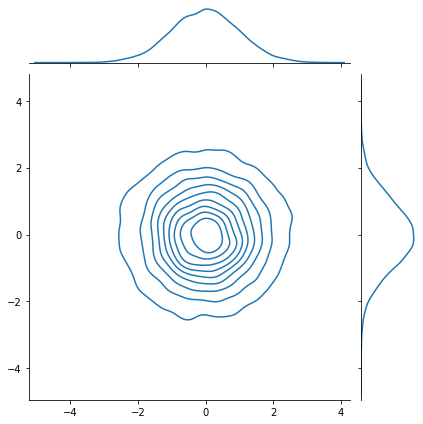

In [20]:
from torch.distributions import MultivariateNormal
import seaborn as sns
mean = torch.Tensor([0, 0])
covariance = torch.Tensor([
    [1, 0],
    [0, 1]
])
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,))
res = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind="kde")
plt.show()

$$\Sigma = \left(\begin{array}{cc}
2 & -1\\
-1 & 2
\end{array}\right)
$$

/Users/shankar/dev/tools/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


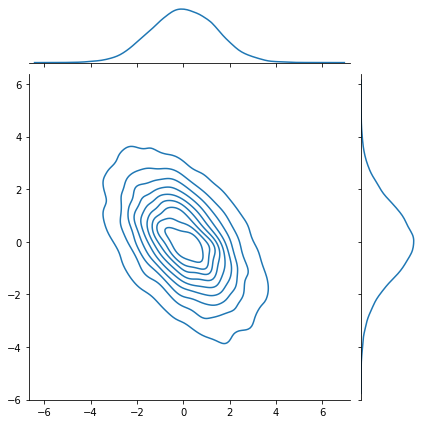

In [21]:
mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
covariant_dist = MultivariateNormal(mean, covariance)
samples = covariant_dist.sample((10000,))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind="kde")
plt.show()

Based on the paper, "[The Fréchet distance between multivariate normal distributions](https://core.ac.uk/reader/82269844)" by Dowson and Landau (1982), the Fréchet distance between two multivariate normal distributions $X$ and $Y$ is:

$$d(X, Y) = \Vert\mu_X-\mu_Y\Vert^2 + \mathrm{Tr}\left(\Sigma_X+\Sigma_Y - 2 \sqrt{\Sigma_X \Sigma_Y}\right)$$

Similar to the formula for univariate Fréchet distance, you can calculate the distance between the means and the distance between the standard deviations. However, calculating the distance between the standard deviations changes slightly here, as it includes the matrix product and matrix square root.  Tr  refers to the trace, the sum of the diagonal elements of a matrix.

In [24]:
import scipy

def matrix_sqrt(x):
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [27]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    part_1 = (mu_x - mu_y) @ (mu_x - mu_y)
    part_2 = torch.trace(sigma_x) + torch.trace(sigma_y) - torch.trace(2*matrix_sqrt(sigma_x @ sigma_y))
                                                                      
    return part_1 + part_2